In [1]:
import csv
import re
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.model_selection import KFold

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,GRU,Dense,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Include this block so that keras 
# # would not use up all the GPU memory.
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [6]:
datafiles_path = './data/drug_sentence_classification.csv'
data_files = pd.read_csv(datafiles_path)

In [7]:
data_files.head()

,neutral_citation,sentence_id,important,sentence
0,[2009] HKCFI 2104,0,False,"## HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009..."
1,[2009] HKCFI 2104,1,False,HCCC241/2008
2,[2009] HKCFI 2104,2,False,IN THE HIGH COURT OF THE
3,[2009] HKCFI 2104,3,False,HONG KONG SPECIAL ADMINISTRATIVE REGION
4,[2009] HKCFI 2104,4,False,COURT OF FIRST INSTANCE


In [8]:
datas_X = data_files['sentence']
datas_Y = data_files['important'].astype(int)

In [9]:
datas_X.head()

0    ##  HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009...
1                                         HCCC241/2008
2                             IN THE HIGH COURT OF THE
3              HONG KONG SPECIAL ADMINISTRATIVE REGION
4                              COURT OF FIRST INSTANCE
Name: sentence, dtype: object

In [28]:
datas_Y.head()

0    0
1    0
2    0
3    0
4    0
Name: important, dtype: int64

In [11]:
data_example = datas_X[0]
data_example

'##  HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009] HKCFI 2104; HCCC 241/2008 (30\r\nMarch 2009)'

In [12]:
type(data_example)

str

In [13]:
#Clean up the data

#Function to clean up data
#•Only take characters inside A-Za-z
#•remove stop words
#•lemmatize

In [14]:
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                if any(map(str.isdigit, w)):
                    filtered_sentence.append("0")
                else:
                    filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

In [15]:
totalX = []
totalY = np.array(datas_Y).reshape((-1,1))
for i, doc in enumerate(datas_X):
    #直接在这里去除\n，防止\n可能会让两句话连接处的两个单词连在一起
    doc = doc.replace("\n"," ")
    totalX.append(cleanUpSentence(doc, stop_words))

In [16]:
# totalX=np.array(totalX)
# emptyX,emptyY,totalX,totalY = totalX[totalX==''],totalY[totalX==''],totalX[totalX!=''],totalY[totalX!='']

In [17]:
totalX

['hksar v mwaniki catherine waithira 0 hkcfi 0 hccc 0 0 march 0',
 '0',
 'high court',
 'hong kong special administrative region',
 'court first instance',
 'criminal case 0 0',
 '',
 'hksar v mwaniki catherine waithira',
 '',
 'deputy high court judge geiser',
 'date 0 march 0 0',
 'present',
 'miss grace chan spp department justicefor hksar mr frederic c whitehouse instructed chin associate 0 accused',
 'offence trafficking dangerous drug',
 'transcript audio recording sentence case',
 'court madam pleaded guilty offence trafficking dangerous drug contrary section 0 0 dangerous drug ordinance cap 0 law hong kong particular 0 june last year chek lap kok international airport possession 0 gramme mixture containing 0 gramme heroin hydrochloride',
 'fact agreed indicate upon arrival hong kong international airport searched quantity heroin form pellet found inside pant wearing subsequently taken hospital 0 pellet heroin discharged body',
 'told police record interview recruited person cal

In [ ]:
xLengths = [len(word_tokenize(x)) for x in totalX]
# h = sorted(xLengths)  #sorted lengths 升序 第一个最小
# maxLength =h[len(h)-1]
maxLength = max(xLengths)
print("max input length is: ",maxLength)

In [ ]:
# maxLength = h[int(len(h) * 0.70)]
# print("70% cover input sequence length up to",maxLength)

In [ ]:
#给每个句子的词标上id
max_vocab_size = 30000
input_tokenizer = Tokenizer(max_vocab_size)
input_tokenizer.fit_on_texts(totalX)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
#pre-padding and pre-truncating
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))

In [ ]:
word_index = input_tokenizer.word_index

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('./embedding/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,max_vocab_size)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
count = 0
num_embedding = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
for word, i in word_index.items():
    if i>=max_vocab_size:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        if word == "0":
            embedding_matrix[i] = num_embedding
        else:
            embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


In [33]:
%%capture output
#Create Keras model
#num_categories 总标签数
num_categories = len(totalY[0])
num_categories
totalX.shape[0]

298702

In [24]:
%%capture output
prediction = []
prediction_index = []
early_stopping = EarlyStopping(patience=5)
histories = []
kf = KFold(n_splits=5)

# strategy = tf.distribute.MirroredStrategy()

for train_index, test_index in kf.split(totalX):
    model = Sequential()
    model.add(Embedding(input_vocab_size, EMBEDDING_DIM,input_length = maxLength, 
                        weights=[embedding_matrix],
                        trainable=False))
    # model.add(Embedding(input_vocab_size, embedding_dim,input_length = maxLength))
    # model.add(GRU(256, dropout=0.5, return_sequences=True))
    # model.add(GRU(256, dropout=0.5))
    model.add(Bidirectional(LSTM(256, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, dropout=0.5)))
    model.add(Dense(num_categories, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])    

    
    trainX = totalX[train_index]
    trainY = totalY[train_index]
    histories.append(model.fit(trainX, trainY, validation_split=0.1, batch_size=512, epochs=50,callbacks=[early_stopping]))
    testX = totalX[test_index]
    testY = totalY[test_index]
    print(model.evaluate(testX, testY, batch_size=512))
    prediction_index.extend(data_files.loc[test_index][['neutral_citation','sentence_id']].values.tolist())
    prediction.extend(model.predict(testX))

output.show()

Epoch 1/50
421/421 [==============================] - 161s 382ms/step - loss: 0.3321 - binary_accuracy: 0.8486 - val_loss: 0.2603 - val_binary_accuracy: 0.8815
Epoch 2/50
421/421 [==============================] - 179s 425ms/step - loss: 0.2866 - binary_accuracy: 0.8720 - val_loss: 0.2484 - val_binary_accuracy: 0.8897
Epoch 3/50
421/421 [==============================] - 192s 455ms/step - loss: 0.2734 - binary_accuracy: 0.8787 - val_loss: 0.2404 - val_binary_accuracy: 0.8917
Epoch 4/50
421/421 [==============================] - 199s 472ms/step - loss: 0.2617 - binary_accuracy: 0.8845 - val_loss: 0.2410 - val_binary_accuracy: 0.8972
Epoch 5/50
421/421 [==============================] - 201s 477ms/step - loss: 0.2550 - binary_accuracy: 0.8883 - val_loss: 0.2361 - val_binary_accuracy: 0.8964
Epoch 6/50
421/421 [==============================] - 200s 474ms/step - loss: 0.2492 - binary_accuracy: 0.8916 - val_loss: 0.2385 - val_binary_accuracy: 0.8931
Epoch 7/50
421/421 [====================

In [25]:
# import csv
# with open('extracted_factors_gru.csv', 'w') as ofile:
#     csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
#     csv_writer.writerow(['trial_id'] + list(data_files.columns)[2:13])
#     for idx, predict in zip(prediction_index, prediction):
#         csv_writer.writerow([idx] + list(predict>0.5))

In [26]:
# for idx, predict in zip(prediction_index, prediction):
#     print(np.where(predict>0.5), 1, 0)
#     break

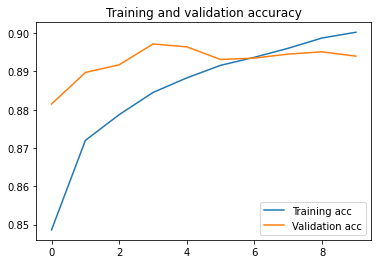

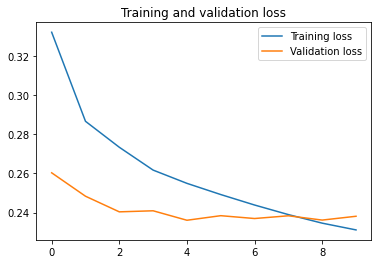

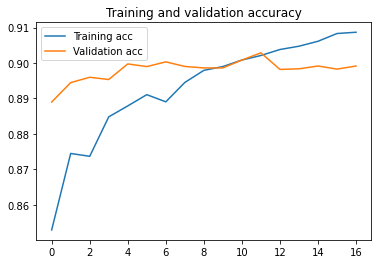

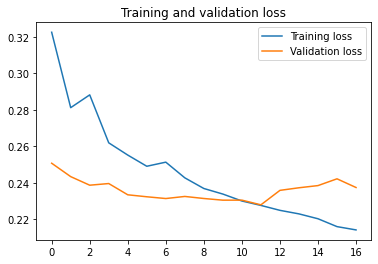

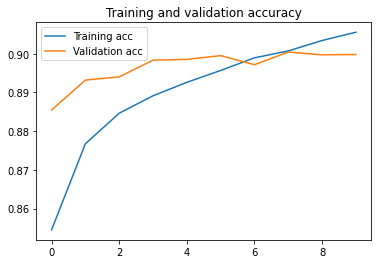

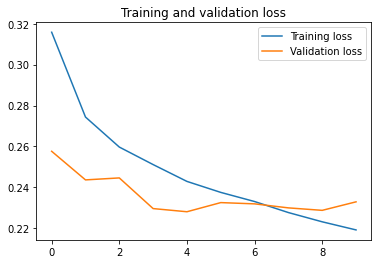

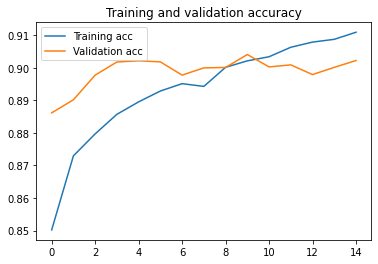

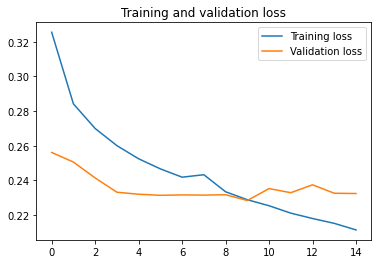

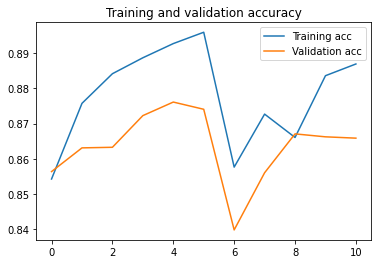

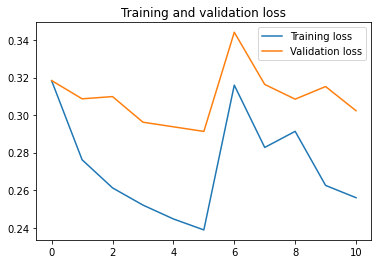

In [27]:
import matplotlib.pyplot as plt


for history in histories:
    
    plt.figure()
    
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss,  label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plt.show()


In [29]:
import csv
with open('./output/extracted_importance_lstm_word2vec.csv', 'w') as ofile:
    csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
    csv_writer.writerow(list(data_files.columns)[:-1])
    for idx, predict in zip(prediction_index, prediction):
        csv_writer.writerow(idx + list(predict>0.5))